In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/My Drive/송규원')

os.getcwd()

'/content/drive/My Drive/송규원'

In [ ]:
sentiword_dict = pd.DataFrame(pd.read_table('SentiWord_Dict.txt' , sep = '\t' , names = ['word' , 'sentiment'] , header = None)) # 군산대학교에서 만든 KNU 한국어 감성사전 활용

sentiword_dict[100:110]

,word,sentiment
100,가량맞고,-1.0
101,가량맞고 야살스러운,-1.0
102,가량맞고 야살스러움,-1.0
103,가려서 좋아하다,-1.0
104,가려운,-1.0
105,가려운 느낌이,-1.0
106,가려운 증상을,-1.0
107,가련하게,-1.0
108,가련하게 여기다,-1.0
109,가련하게 여김,-1.0


**<군산대학교에서 만든 KNU 한국어 감성사전을 활용할 경우>** 

문제점 1. 2-gram 이상의 단어의 경우 어근이 같더라도 뒤에 나오는 단어에 의해 긍부정이 결정됨 

ex) 원하는 대로 -> 긍정 vs 원하지 않는 -> 부정

ex) 않는 -> 부정 vs 믿어 의심치 않는 -> 긍정

문제점 2. Word가 너무 문어체적

# 네이버 영화 리뷰 데이터 활용

## 1. 데이터 정제

### 1. 데이터 로드

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

!pip3 install konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt, Mecab

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f0b63905b50>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 2. 중복 리뷰 제거

In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True)

### 3. Null 값 제거

In [ ]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
train_data = train_data.dropna(how = 'any')

### 4. 정규 표현식 수행

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace = True)

train_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


**정규 표현식 수행 후 공백 리뷰 제거**

In [ ]:
train_data.loc[train_data.document.isnull()].head()

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [ ]:
train_data = train_data.dropna(how = 'any')

**Test Data도 동일하게 적용**

In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


## 2. 토큰화

In [ ]:
X_train = []

for sentence in tqdm(train_data['document']) :
  
    tokenized_sentence = okt.morphs(sentence, stem=True , norm = True) # 토큰화
    X_train.append(tokenized_sentence)

100%|██████████| 145393/145393 [26:52<00:00, 90.16it/s] 


**Test Data도 동일하게 적용**

In [ ]:
X_test = []

for sentence in tqdm(train_data['document']) :

    tokenized_sentence = okt.morphs(sentence, stem=True , norm = True) # 토큰화
    X_test.append(tokenized_sentence)

100%|██████████| 145393/145393 [25:07<00:00, 96.44it/s]


## 3. 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'이': 1, '영화': 2, '보다': 3, '하다': 4, '의': 5, '에': 6, '가': 7, '을': 8, '도': 9, '은': 10, '들': 11, '는': 12, '를': 13, '없다': 14, '이다': 15, '있다': 16, '좋다': 17, '너무': 18, '재밌다': 19, '다': 20, '정말': 21, '한': 22, '것': 23, '되다': 24, '적': 25, '만': 26, '같다': 27, '진짜': 28, '으로': 29, '아니다': 30, '않다': 31, '로': 32, '점': 33, '에서': 34, '만들다': 35, '과': 36, '나오다': 37, '연기': 38, '평점': 39, '내': 40, '최고': 41, '그': 42, '나': 43, '안': 44, '인': 45, '왜': 46, '스토리': 47, '생각': 48, '못': 49, '드라마': 50, '감동': 51, '사람': 52, '게': 53, '보고': 54, 'ㅋㅋㅋ': 55, '말': 56, '이렇다': 57, '아깝다': 58, '고': 59, '더': 60, '배우': 61, '때': 62, 'ㅋㅋ': 63, '와': 64, '아': 65, '감독': 66, '거': 67, '그냥': 68, '재미있다': 69, '뭐': 70, '시간': 71, '재미': 72, '내용': 73, '요': 74, '까지': 75, '주다': 76, '중': 77, '좀': 78, '자다': 79, '하고': 80, '지루하다': 81, '재미없다': 82, '쓰레기': 83, '수': 84, '네': 85, '가다': 86, '모르다': 87, '들다': 88, '그렇다': 89, '싶다': 90, '작품': 91, '알다': 92, '사랑': 93, '하나': 94, '다시': 95, '마지막': 96, '볼': 97, '잘': 98, '지': 99, '정도': 100, '저': 101, '처음': 102, '이렇게': 10

### 1. 희소 단어 제거

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items() :
  
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold) :

        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42962
등장 빈도가 2번 이하인 희귀 단어의 수: 23704
단어 집합에서 희귀 단어의 비율: 55.17434011451981
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5308715723725235


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩, OOV 토큰을 고려하여 + 2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :' , vocab_size)

단어 집합의 크기 : 19260


In [ ]:
tokenizer = Tokenizer(vocab_size , oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train) 

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 2. 라벨링

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 3. 희소 단어 제거로 인한 Null 값 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 4. 패딩

### 1. 평균 리뷰 길이 확인

리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 13.12573507665431


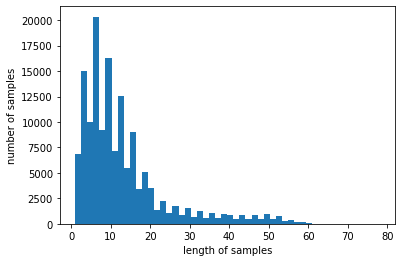

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 2. 최대 길이 설정 & 패딩

In [ ]:
max_len = 30

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 5. 모델링



In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1818/1818 [==============================] - ETA: 0s - loss: 0.3895 - acc: 0.8229
Epoch 1: val_acc improved from -inf to 0.84325, saving model to best_model.h5
1818/1818 [==============================] - 171s 92ms/step - loss: 0.3895 - acc: 0.8229 - val_loss: 0.3571 - val_acc: 0.8433
Epoch 2/15
1818/1818 [==============================] - ETA: 0s - loss: 0.3278 - acc: 0.8566
Epoch 2: val_acc improved from 0.84325 to 0.85426, saving model to best_model.h5
1818/1818 [==============================] - 158s 87ms/step - loss: 0.3278 - acc: 0.8566 - val_loss: 0.3378 - val_acc: 0.8543
Epoch 3/15
1817/1818 [============================>.] - ETA: 0s - loss: 0.3032 - acc: 0.8708
Epoch 3: val_acc improved from 0.85426 to 0.85777, saving model to best_model.h5
1818/1818 [==============================] - 158s 87ms/step - loss: 0.3032 - acc: 0.8708 - val_loss: 0.3268 - val_acc: 0.8578
Epoch 4/15
1817/1818 [============================>.] - ETA: 0s - loss: 0.2843 - acc: 0.8805
Epoch 4: v

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1926000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,043,377
Trainable params: 2,043,377
Non-trainable params: 0
_________________________________________________________________


## 6. 예측

### 1. 예측 함수 생성

In [ ]:
def sentiment_predict(new_sentence) :

  # 정규 표현식 수행
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]' , '' , new_sentence)

  # 토큰화
  tokenized_sentence = okt.morphs(new_sentence, stem=True , norm = True) # 토큰화

  # 정수 인코딩
  encoded = tokenizer.texts_to_sequences([tokenized_sentence])

  # 패딩 
  pad_new = pad_sequences(encoded, maxlen = max_len) 
  
  # 예측
  score = float(model.predict(pad_new)) 
  
  if(score > 0.5) :
    
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))

  else :

    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

### 2. 영화 리뷰가 아닌 앱 리뷰를 통한 검증

#### 디지니+ 리뷰 분석

##### 리뷰 1)

다른 리뷰에도 있듯이 개선해야할게 공통점이 최소 2가지 있네요 1. 다음회차나 전회차로 넘어가기 (이건 일반 동영상 어플에서도 지원하는데 없어서 상당히 불편) 2. 배속 (한국인 특성상 빨리보기원하는 사람 많음 그거 아니고도 언어 트레이닝하는사람들은 느리게 배속하여 보는 사람도 있음) 3.화면밝기,사운드조정 (첫번째 사항과 동일하게 일반적인 동영상플레이어플에도 지원되는 지극히 필요한 최소한의 기능인데도 이것조차 지원되지않음) 하루빨리 개선되었으면 합니다

In [ ]:
sentiment_predict('다른 리뷰에도 있듯이 개선해야할게 공통점이 최소 2가지 있네요 1. 다음회차나 전회차로 넘어가기 (이건 일반 동영상 어플에서도 지원하는데 없어서 상당히 불편) 2. 배속 (한국인 특성상 빨리보기원하는 사람 많음 그거 아니고도 언어 트레이닝하는사람들은 느리게 배속하여 보는 사람도 있음) 3.화면밝기,사운드조정 (첫번째 사항과 동일하게 일반적인 동영상플레이어플에도 지원되는 지극히 필요한 최소한의 기능인데도 이것조차 지원되지않음) 하루빨리 개선되었으면 합니다')

57.43% 확률로 부정 리뷰입니다.



##### 리뷰 2) 
넷플처럼 스크립트 제공좀 해주세요. 그리고 대사로 되감기 기능도요..10초단위 되감기는 너무 불편합니다. 스크립트는 직접 받아적어서 만든다 하더라도.. 되감기가 대사별로 안되는건 너무 불편합니다. 앱이 구식이에요. Pc에서도 조절이 아무것도 안되다니.. 플레이어 기능이 꽝이라.. 영어 학습자까지 흡수하기에는 부족한 플레이어 입니다. 구려요 구려

In [ ]:
sentiment_predict('넷플처럼 스크립트 제공좀 해주세요. 그리고 대사로 되감기 기능도요..10초단위 되감기는 너무 불편합니다. 스크립트는 직접 받아적어서 만든다 하더라도.. 되감기가 대사별로 안되는건 너무 불편합니다. 앱이 구식이에요. Pc에서도 조절이 아무것도 안되다니.. 플레이어 기능이 꽝이라.. 영어 학습자까지 흡수하기에는 부족한 플레이어 입니다. 구려요 구려.')

99.11% 확률로 부정 리뷰입니다.



#### pdf 뷰어 리뷰

##### 리뷰 1)
전반적으로 불만은 없는데, 한 가지 치명적인 단점이 있습니다. 좁은 화면에서 목차를 보기가 어렵습니다. 작은 분할화면, 팝업화면 등으로 좁은 화면으로 볼 때 목차를 보려면 맨 오른쪽 ... 을 눌러서 내용탭을 누르면 되는데, 이때 목차가 지나치게 아래로 스크롤 돼서 목차 마지막 일부분과 빈공간만 보입니다. 창을 조금만 올리면 다시 원상복구 되버리고 일정 수준 이상 올리면 아직 다 위로 올리지도 않았는데 지멋대로 내용탭이 닫힙니다. 무조건 스크롤 원상 복구, 탭 종료가 되어버립니다. 그래서 항상 다시 창 크기를 키우고 목차를 선택한 후 줄이는 식으로 불편하게 사용하고 있습니다.

In [ ]:
sentiment_predict('전반적으로 불만은 없는데, 한 가지 치명적인 단점이 있습니다. 좁은 화면에서 목차를 보기가 어렵습니다. 작은 분할화면, 팝업화면 등으로 좁은 화면으로 볼 때 목차를 보려면 맨 오른쪽 ... 을 눌러서 내용탭을 누르면 되는데, 이때 목차가 지나치게 아래로 스크롤 돼서 목차 마지막 일부분과 빈공간만 보입니다. 창을 조금만 올리면 다시 원상복구 되버리고 일정 수준 이상 올리면 아직 다 위로 올리지도 않았는데 지멋대로 내용탭이 닫힙니다. 무조건 스크롤 원상 복구, 탭 종료가 되어버립니다. 그래서 항상 다시 창 크기를 키우고 목차를 선택한 후 줄이는 식으로 불편하게 사용하고 있습니다.')

86.46% 확률로 긍정 리뷰입니다.



##### 리뷰 2)
위에 작업표시줄? 같은거 없애고 pdf 파일 스크롤 할때 자꾸 다시 떴다가 없어지면서 버벅거려서 눈이 아프네요. 위에 뜨는 도구모음이 확실하게 한번 탭하면 없어지고 다시 탭해야 나타나게 해야될거 같아요. 스크롤할때마다 나타났다가 사라졌다가하니 눈이 아파서 읽을수가 없네요. 또 텍스트 선택을 했을때 갤럭시 기본 기능 중 사전이 바로 연결이 안되는게 아쉬워요. 모르는 단어 있으면 노트 주석을 만들어서 직접 그 단어 치고 선택을 해야 사전을 찾을수 있어서 좀 불편해요

In [ ]:
sentiment_predict('위에 작업표시줄? 같은거 없애고 pdf 파일 스크롤 할때 자꾸 다시 떴다가 없어지면서 버벅거려서 눈이 아프네요. 위에 뜨는 도구모음이 확실하게 한번 탭하면 없어지고 다시 탭해야 나타나게 해야될거 같아요. 스크롤할때마다 나타났다가 사라졌다가하니 눈이 아파서 읽을수가 없네요. 또 텍스트 선택을 했을때 갤럭시 기본 기능 중 사전이 바로 연결이 안되는게 아쉬워요. 모르는 단어 있으면 노트 주석을 만들어서 직접 그 단어 치고 선택을 해야 사전을 찾을수 있어서 좀 불편해요')

81.15% 확률로 부정 리뷰입니다.



#### To-Do List - 스케줄 플래너 & 리마인더 리뷰

##### 리뷰 1)
광고가 너무 많이 나옵니다. 설치하고 이틀은 광고가 안나오고 잘 썼는데 오늘 되니까 일정 등록하고 나오면 광고 일정 하나 수정하면 광고 이런식으로 굉장히 많이 나와요. 어플 ui는 상당히 직관적으로 잘 만들어졌고 수정도 간편해서 결제 해서 쓸것 같지만 설치한지 이틀만에 광고때문에 영구구매 플랜을 구입하려니까 짜증나네요.

In [ ]:
sentiment_predict('광고가 너무 많이 나옵니다. 설치하고 이틀은 광고가 안나오고 잘 썼는데 오늘 되니까 일정 등록하고 나오면 광고 일정 하나 수정하면 광고 이런식으로 굉장히 많이 나와요. 어플 ui는 상당히 직관적으로 잘 만들어졌고 수정도 간편해서 결제 해서 쓸것 같지만 설치한지 이틀만에 광고때문에 영구구매 플랜을 구입하려니까 짜증나네요.')

80.99% 확률로 긍정 리뷰입니다.



##### 리뷰 2)
다 좋은데 작업 정렬을 고정할 수 있는 기능과 연속된 날짜에 시행되는 일을 표시할 수 있었으면 좋겠습니다. 또한 과제에서 "모두"를 선택했을 때 카테고리에 따른색깔 변화라던지 카테고리가 다른 것들이 서로 구분되면서 한눈에 보였으면 합니다. 이것만 추가되면 별 5개도 아깝지 않은 좋은 앱입니다.

In [ ]:
sentiment_predict('다 좋은데 작업 정렬을 고정할 수 있는 기능과 연속된 날짜에 시행되는 일을 표시할 수 있었으면 좋겠습니다. 또한 과제에서 "모두"를 선택했을 때 카테고리에 따른색깔 변화라던지 카테고리가 다른 것들이 서로 구분되면서 한눈에 보였으면 합니다. 이것만 추가되면 별 5개도 아깝지 않은 좋은 앱입니다.')

99.43% 확률로 긍정 리뷰입니다.



# Reference

*   [네이버 영화 리뷰로 감성 분류](https://wikidocs.net/44249)



